In [1]:
import os
import sys
import math
import logging
from pathlib import Path
from datetime import datetime

import numpy as np
import scipy as sp
from scipy import stats
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("whitegrid")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

In [2]:
np.random.seed(42)

# Honey, I shrunk the target variable!

Read first the accompanying article on my [blog](https://florianwilhelm.info/2020/05/honey_i_shrunk_the_target_variable/) to understand what's going on here.

Download the data from [Kaggle used-cars database](https://www.kaggle.com/vfsousas/autos), unzip it and put it under `../data/raw`

In [3]:
!ls ../data/raw/  # this should show "autos.csv"

autos.csv


In [4]:
data_dir = Path('../data/raw')
autos_csv = data_dir / Path('autos.csv')

In [5]:
df = pd.read_csv(autos_csv, encoding='cp850', parse_dates=['dateCreated', 'lastSeen'])
print(list(df.columns))

['dateCrawled', 'name', 'seller', 'offerType', 'price', 'abtest', 'vehicleType', 'yearOfRegistration', 'gearbox', 'powerPS', 'model', 'kilometer', 'monthOfRegistration', 'fuelType', 'brand', 'notRepairedDamage', 'dateCreated', 'nrOfPictures', 'postalCode', 'lastSeen']


Let's concentrate only on working cars in a reasonable price range which are sold

In [6]:
df = df.query('price <= 50_000 and notRepairedDamage == "nein" and price > 200 and '
              'offerType == "Angebot" and 1910 <= yearOfRegistration')
# make sure it's really a used car
df = df[df['yearOfRegistration'] < df['dateCreated'].dt.year]

In [7]:
# create 1000 Euro bins for price-ranges
bins = 1000*np.arange(50)

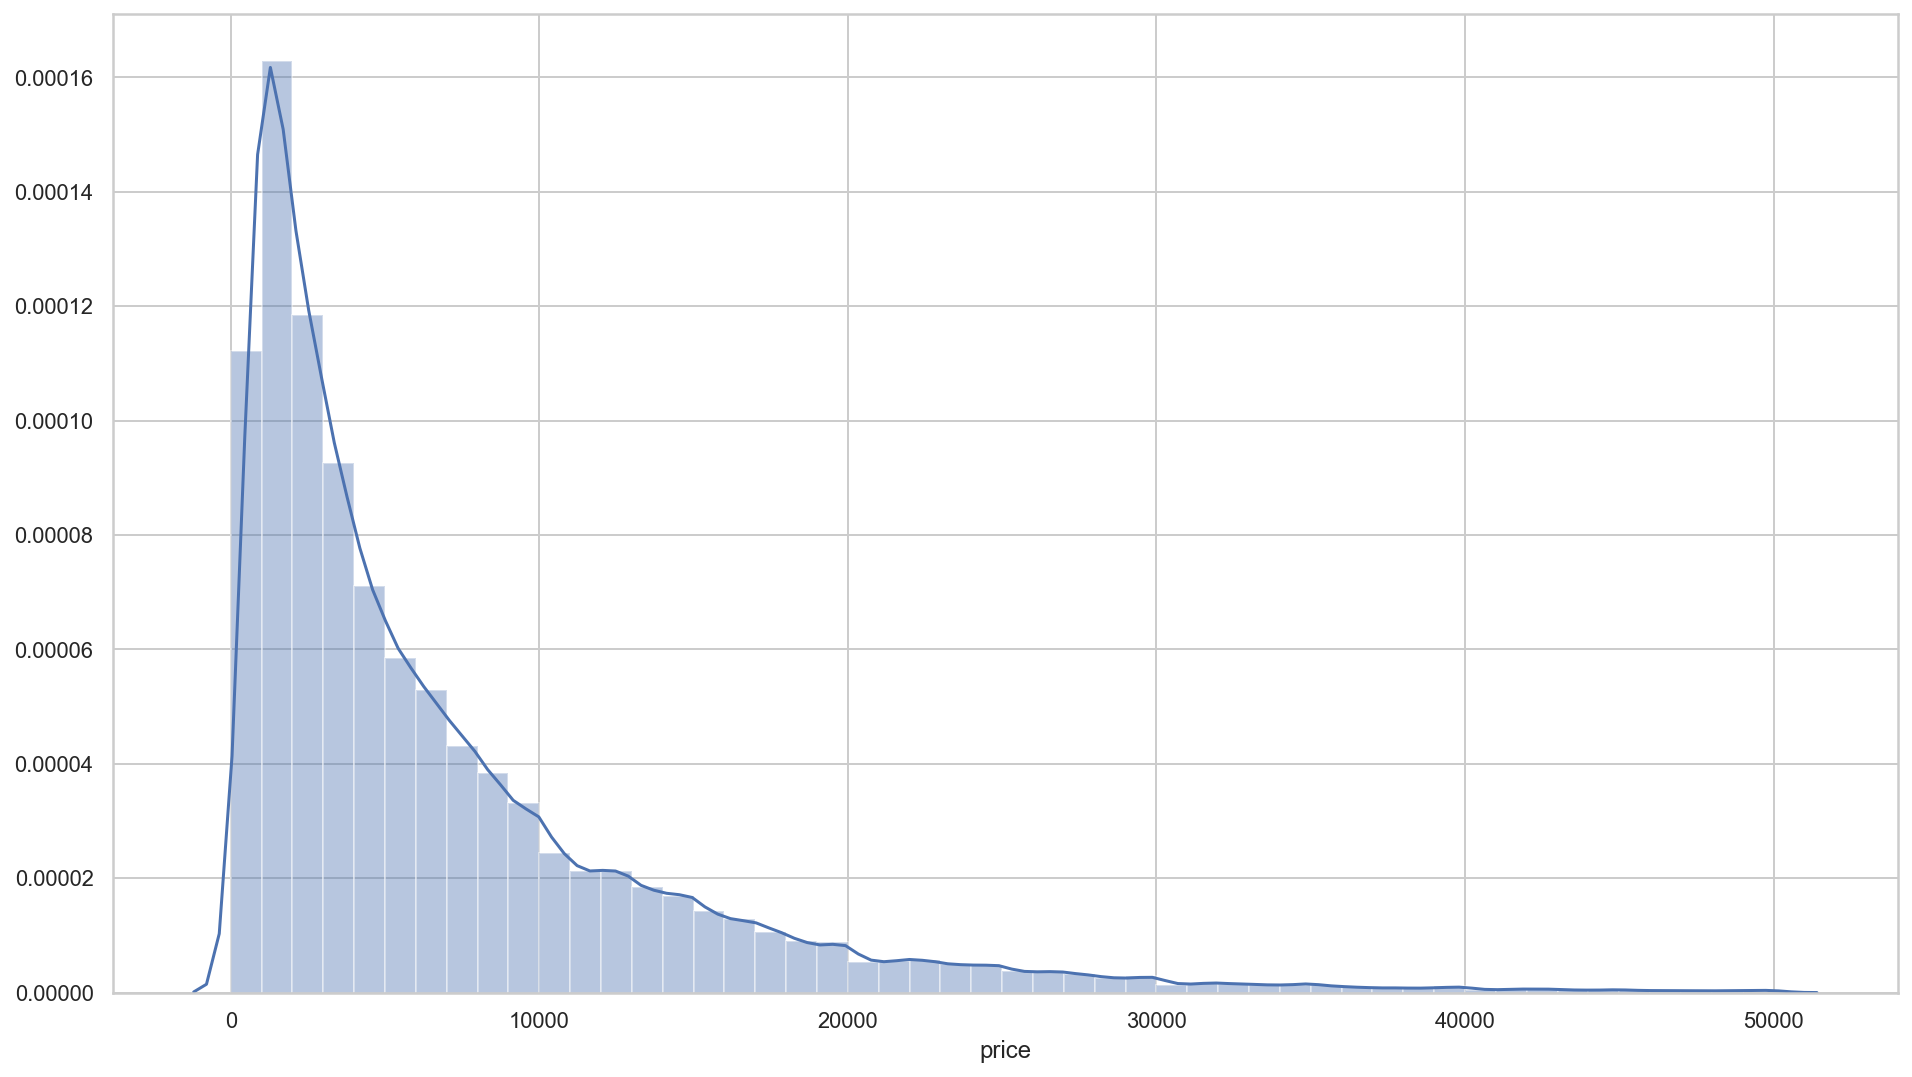

In [8]:
sns.distplot(df.price, bins=bins);

The price looks definitely not normal distributed rather log-normal distributed. Let's check that visually.

We fit a log-normal distribution, sample from it and see it it looks similar

In [9]:
shape, loc, scale = stats.lognorm.fit(df.price, floc=0.)
dist = stats.lognorm(shape, loc, scale)
rvs = dist.rvs(100_000)

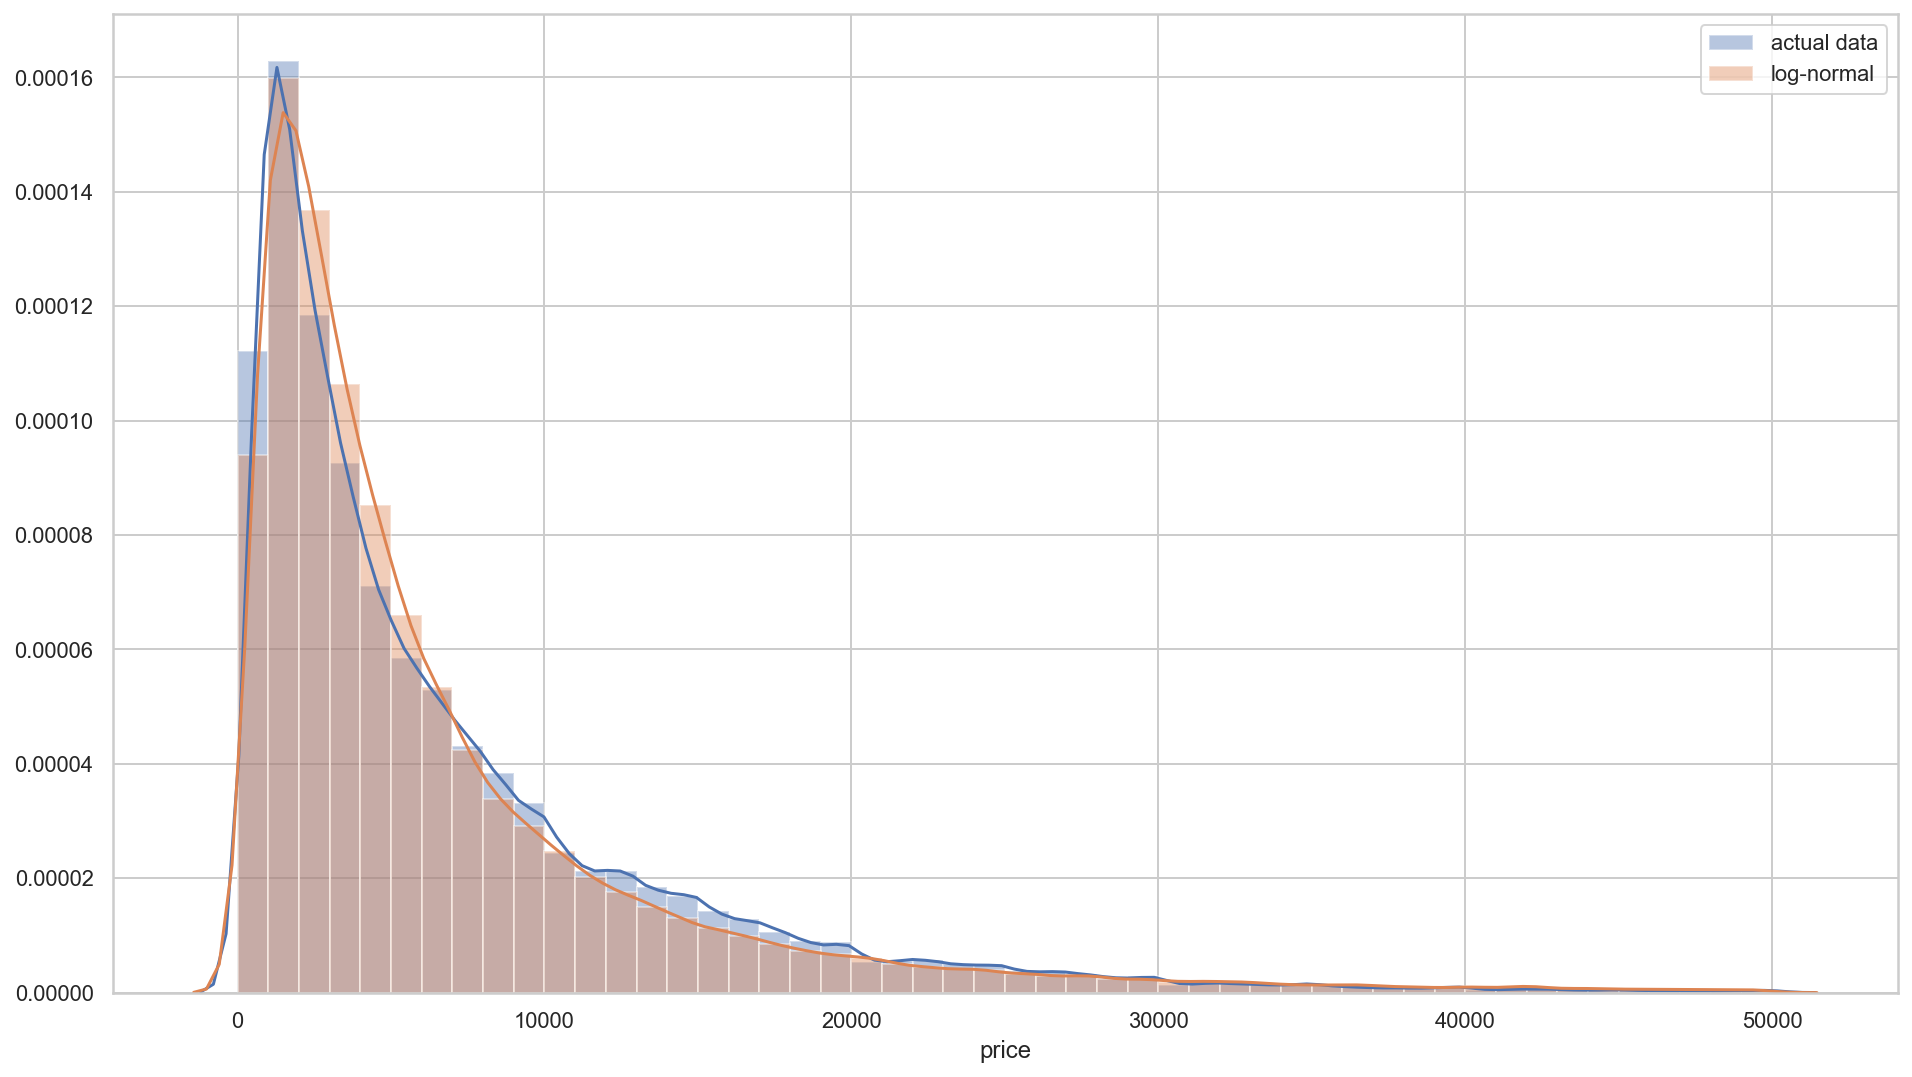

In [10]:
sns.distplot(df.price, bins=bins, label='actual data')
sns.distplot(rvs[rvs<50_000], bins=bins, label='log-normal')
plt.legend();

## Distribution of the target variable

In [11]:
# use some simple linear model to generate the target variable
N = 10000
x = np.random.randint(2, size=N)
y = x + 0.3*np.random.randn(N)

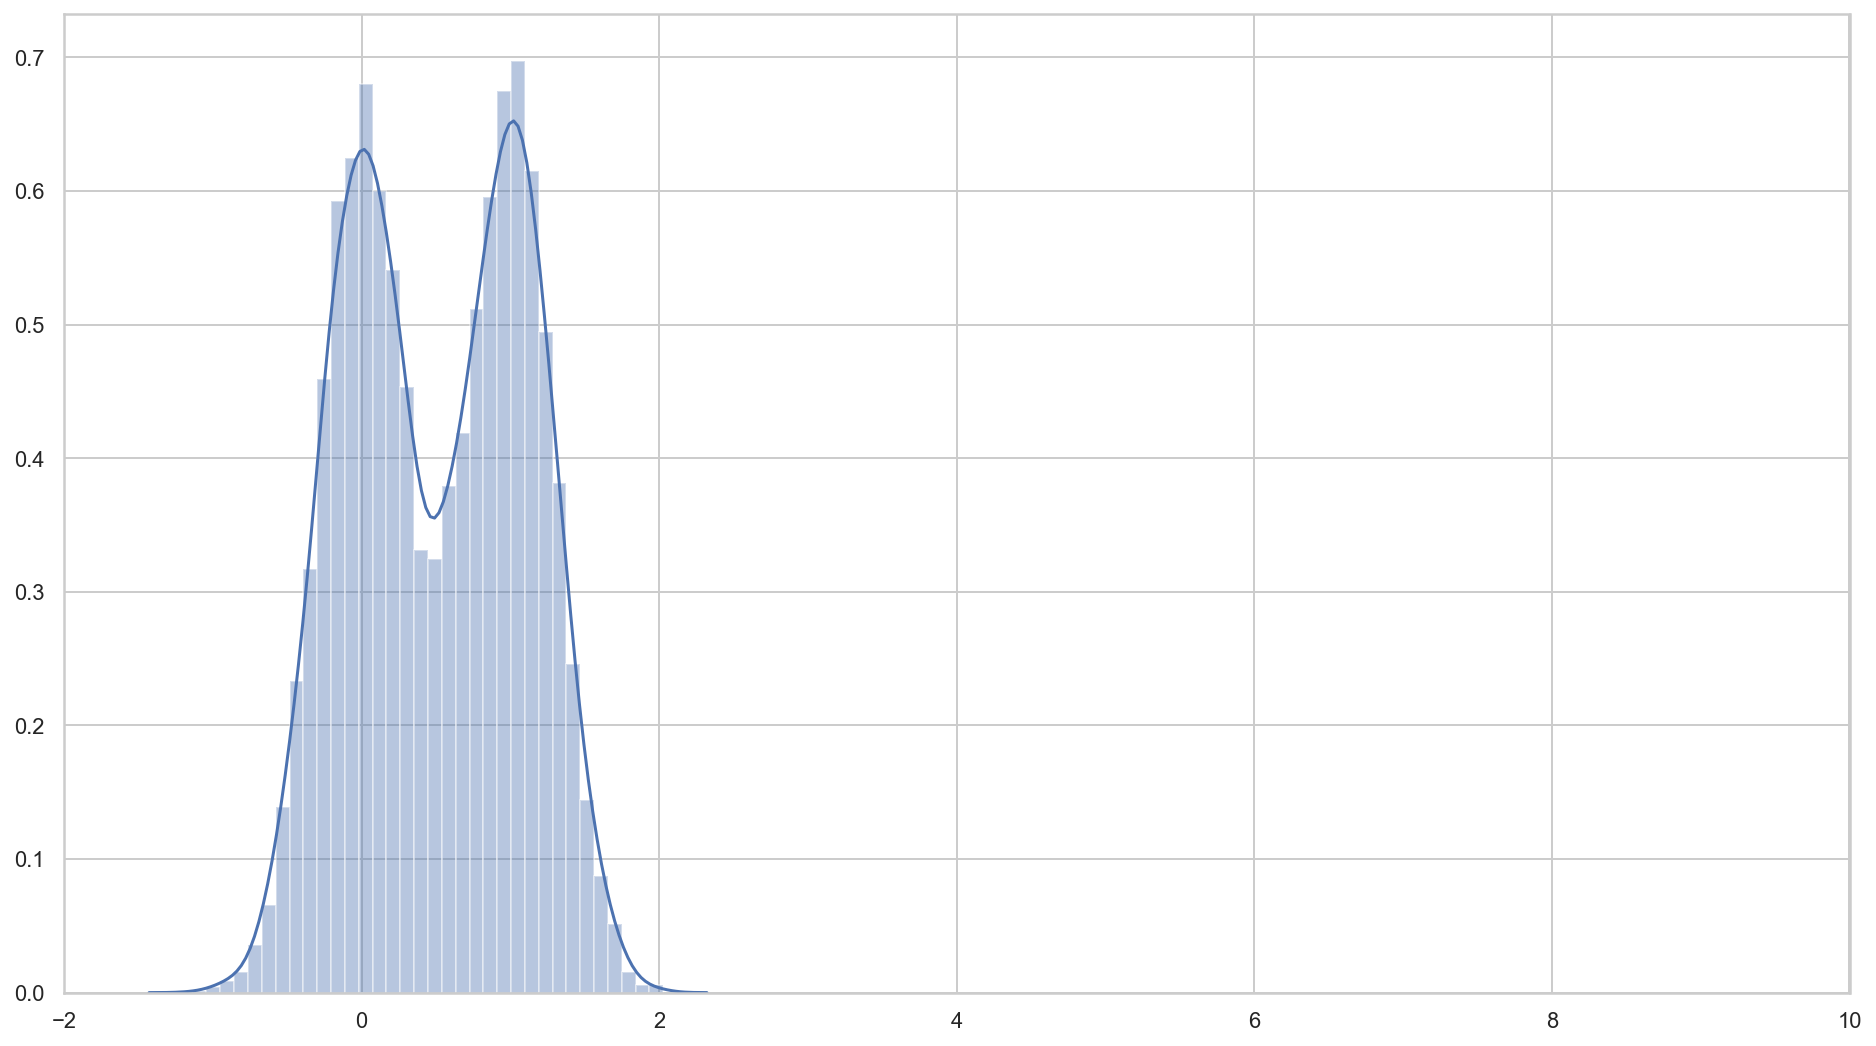

In [12]:
# obviously, the outcome of a linear model doesn't have to be normally distributed.
sns.distplot(y)
plt.xlim(-2, 10);

## Analysis of the residual distribution

In [13]:
# all kinds of error measures we need
def rmse(y_pred, y_true):
    """Root Mean Squared Error"""
    # not taking the root, i.e. MSE, would not change the actual minimum point
    return np.sqrt(np.mean((y_true - y_pred)**2))


def mae(y_pred, y_true):
    """Mean Absolute Error"""
    return np.mean(np.abs(y_true - y_pred))


def mape(y_pred, y_true):
    """Mean Average Percentage Error"""
    return np.mean(np.abs((y_true - y_pred)/y_true))


def rmspe(y_pred, y_true):
    """Root Mean Squared Percentage Error"""
    return np.sqrt(np.mean(((y_true - y_pred)/y_true)**2))

In [14]:
y = df.price.to_numpy()

In [15]:
res = sp.optimize.minimize(rmse, 1., args=(y,))
res

      fun: 7215.2174084874705
 hess_inv: array([[7230.55363496]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 36
      nit: 5
     njev: 12
   status: 0
  success: True
        x: array([6807.6770554])

In [16]:
np.mean(y)

6807.761855422959

In [17]:
res = sp.optimize.minimize(mae, 1., options=dict(gtol=2e-4), args=(y,))
res

      fun: 4796.8698839141825
 hess_inv: array([[879.97157561]])
      jac: array([6.10351562e-05])
  message: 'Optimization terminated successfully.'
     nfev: 213
      nit: 8
     njev: 71
   status: 0
  success: True
        x: array([4200.])

In [18]:
np.median(y)

4200.0

## Shrinking the target variable

In [19]:
y_log = np.log(df.price.to_numpy())

In [20]:
res_y = sp.optimize.minimize(rmse, 1., args=(y_log,), tol=1e-16)
res_y

      fun: 1.0632889349620418
 hess_inv: array([[1.06895454]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 36
      nit: 6
     njev: 12
   status: 0
  success: True
        x: array([8.31228458])

In [21]:
np.exp(res_y.x)

array([4073.60886082])

This value rather resembles the median of the original distribution.

Let's see how it looks for our fitted log-normal distribution.

In [22]:
np.median(rvs)

4085.1016877094935

In [23]:
rvs_log = np.log(rvs)
res_rvs = sp.optimize.minimize(rmse, 1., args=(rvs_log,), tol=1e-10)
res_rvs

      fun: 1.0642469096947056
 hess_inv: array([[1.06425975]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 30
      nit: 5
     njev: 10
   status: 0
  success: True
        x: array([8.31331266])

In [24]:
np.exp(res_rvs.x)

array([4077.79898614])

So it's even closer to the median of the original distribution!

Let's calculate the mean of the original distrubtion using the transformed one.

In [25]:
mu = res_y.x[0]
sigma2 = rmse(mu, y_log)**2
np.exp(mu + sigma2/2)

7169.392938612738

which is now much closer to 

In [26]:
np.mean(y)

6807.761855422959

and for the log-normal distribution

In [27]:
mu = res_rvs.x[0]
sigma2 = rmse(mu, rvs_log)**2
np.exp(mu + sigma2/2)

7184.084700358445

we get the expected value up to some error due to the sampling

In [28]:
np.mean(rvs)

7176.335573001948

Let's do the same for MAPE. First for y:

In [29]:
sp.optimize.minimize(mape, 1000., args=(y,))

      fun: 0.6988380535651055
 hess_inv: array([[1]])
      jac: array([9.4473362e-06])
  message: 'Optimization terminated successfully.'
     nfev: 39
      nit: 1
     njev: 13
   status: 0
  success: True
        x: array([1286.45831626])

In [30]:
mu = res_y.x[0]
sigma2 = rmse(mu, rvs_log)**2
np.exp(mu - sigma2)

1312.4646251189145

and then for the log-normal distribution:

In [31]:
sp.optimize.minimize(mape, 1., args=(rvs,), tol=1e-10)

      fun: 0.712700748148407
 hess_inv: array([[613609.28087362]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 57
      nit: 7
     njev: 19
   status: 0
  success: True
        x: array([1311.26427451])

In [32]:
mu = res_rvs.x[0]
sigma2 = rmse(mu, rvs_log)**2
np.exp(mu - sigma2)

1313.816018474146

So we see that a correction of -sigma2 is needed to transform the minimum point of the log-transformed target back to get the minimum point of MAPE on the untransformed target.

## Transforming the target for fun and profit

Shuffle the rows for KFold later

In [33]:
# decrease to trade accuracy for speed
CV_SPLITS = 10
FRACTION = 1.0

In [34]:
# down- or resample data for CV later on
df = df.sample(frac=FRACTION).reset_index(drop=True)

Merge year and month of registration into `dateOfRegistration` in order to calculate `ageInYears` as well as `mileageOverAge`.

In [35]:
df['monthOfRegistration'] = df['monthOfRegistration'].replace(0, 7)
df['dateOfRegistration'] = df.apply(
    lambda ds: datetime(ds['yearOfRegistration'], ds['monthOfRegistration'], 1), axis=1)
df['ageInYears'] = df.apply(
    lambda ds: (ds['dateCreated'] - ds['dateOfRegistration']).days / 365, axis=1)
df['mileageOverAge'] = df['kilometer'] / df['ageInYears']

In [36]:
FEATURES = ["vehicleType", 
            "ageInYears",
            "mileageOverAge",
            "gearbox", 
            "powerPS",
            "model",
            "kilometer", 
            "fuelType",
            "brand",
            "price"]
df = df[FEATURES].copy()

In [37]:
for col, dtype in zip(df.columns, df.dtypes):
    if dtype is np.dtype('O'):
        df[col] = df[col].astype('category').cat.codes

In [38]:
y = df['price'].to_numpy()
X = df.drop(columns='price').to_numpy()

In [39]:
METRICS = ['rmse', 'mae', 'mape', 'rmspe']

In [40]:
def get_corr(y_true, y_pred_log, error_func, **kwargs):
    """Determine correction delta for exp transformation"""
    def cost_func(delta):
        return error_func(np.exp(delta + y_pred_log), y_true)
    
    res = sp.optimize.minimize(cost_func, 0., **kwargs)
    if res.success:
        return res.x
    else:
        raise RuntimeError(f"Finding correction term failed!\n{res}")

In [41]:
reg = RandomForestRegressor()
results = []
for i, (train_idx, test_idx) in enumerate(KFold(n_splits=CV_SPLITS).split(X)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)
    
    # raw untransformed target
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    res = dict(target='raw',
               split=i,
               rmse=rmse(y_pred, y_test),
               mae=mae(y_pred, y_test),
               mape=mape(y_pred, y_test),
               rmspe=rmspe(y_pred, y_test))
    results.append(res)
    
    # log-transformed target
    y_train_log = np.log(y_train)
    reg.fit(X_train, y_train_log)
    y_log_pred = reg.predict(X_test)
    y_pred = np.exp(y_log_pred)
    res = dict(target='log & no corr',
               split=i,
               rmse=rmse(y_pred, y_test),
               mae=mae(y_pred, y_test),
               mape=mape(y_pred, y_test),
               rmspe=rmspe(y_pred, y_test))
    results.append(res)
    
    # log-transformed target and sigma2 correction
    y_val_log_pred = reg.predict(X_val)
    sigma2 = rmse(y_val_log_pred, np.log(y_val))**2
    res = dict(target='log & sigma2 corr',
               split=i,
               rmse=rmse(np.exp(y_log_pred + 0.5*sigma2), y_test),
               mae=mae(np.exp(y_log_pred), y_test),
               mape=mape(np.exp(y_log_pred - sigma2), y_test),
               rmspe=rmspe(np.exp(y_log_pred - 1.5*sigma2), y_test))
    results.append(res)
    
    # log-transformed target and fitted correction
    res = dict(target='log & fitted corr',
               split=i,
               rmse=rmse(np.exp(y_log_pred + get_corr(y_val, 
                                                      y_val_log_pred, 
                                                      rmse, 
                                                      options={'gtol': 1e-04})), 
                         y_test),
               mae=mae(np.exp(y_log_pred + get_corr(y_val, 
                                                    y_val_log_pred, 
                                                    mae, 
                                                    options={'gtol': 0.3})), 
                       y_test),
               mape=mape(np.exp(y_log_pred + get_corr(y_val, 
                                                      y_val_log_pred, 
                                                      mape , 
                                                      options={'gtol': 1e-04})), 
                         y_test),
               rmspe=rmspe(np.exp(y_log_pred + get_corr(y_val, 
                                                        y_val_log_pred, 
                                                        rmspe)), 
                           y_test))
    results.append(res)

    
df_res = pd.DataFrame(results, columns=['split', 'target', *METRICS])

In [42]:
df_res

,split,target,rmse,mae,mape,rmspe
0,0,raw,2368.364231,1249.343044,0.342704,1.651721
1,0,log & no corr,2464.504824,1253.188073,0.307301,1.561717
2,0,log & sigma2 corr,2475.476390,1253.188073,0.305424,1.279026
3,0,log & fitted corr,2449.232648,1251.347176,0.299577,0.858787
4,1,raw,2290.307843,1229.583185,0.319396,1.341149
5,1,log & no corr,2395.190502,1238.876379,0.286027,1.208032
6,1,log & sigma2 corr,2403.609581,1238.876379,0.286394,0.986899
7,1,log & fitted corr,2376.039067,1237.597447,0.278821,0.744303
8,2,raw,2289.312462,1228.787189,0.325569,1.548788
9,2,log & no corr,2358.207546,1218.860320,0.290537,1.409805


In [43]:
df_res_rel = (df_res.groupby('split')
                    .apply(lambda X: (X[METRICS].iloc[1:] / X[METRICS].iloc[0] - 1.)
                                      .set_index(X['target'].iloc[1:]))
             )

In [44]:
df_res_rel.applymap(lambda x: f"{x:+.2%}")

rmse     mae     mape    rmspe
split target                                             
0     log & no corr      +4.06%  +0.31%  -10.33%   -5.45%
      log & sigma2 corr  +4.52%  +0.31%  -10.88%  -22.56%
      log & fitted corr  +3.41%  +0.16%  -12.58%  -48.01%
1     log & no corr      +4.58%  +0.76%  -10.45%   -9.93%
      log & sigma2 corr  +4.95%  +0.76%  -10.33%  -26.41%
      log & fitted corr  +3.74%  +0.65%  -12.70%  -44.50%
2     log & no corr      +3.01%  -0.81%  -10.76%   -8.97%
      log & sigma2 corr  +4.06%  -0.81%  -10.38%  -25.91%
      log & fitted corr  +2.40%  -0.85%  -12.86%  -48.89%
3     log & no corr      +5.26%  +0.18%  -11.02%  -11.88%
      log & sigma2 corr  +5.45%  +0.18%  -11.37%  -27.83%
      log & fitted corr  +4.46%  +0.07%  -13.31%  -49.28%
4     log & no corr      +1.94%  -0.65%  -11.56%  -15.15%
      log & sigma2 corr  +3.07%  -0.65%  -11.92%  -30.93%
      log & fitted corr  +1.40%  -0.76%  -13.96%  -51.73%
5     log & no corr      +4.31%  +0.51%  -10.19%   -8.35%
      log & sigma2 corr  +5.07%  +0.51%  -10.48%  -25.49%
      log & fitted corr  +3.65%  +0.41%  -12.50%  -51.44%
6     log & no corr      +2.56%  -1.05%  -12.06%  -14.96%
      log & sigma2 corr  +3.80%  -1.05%  -12.31%  -30.69%
      log & fitted corr  +2.09%  -1.08%  -14.44%  -45.05%
7     log & no corr      +2.53%  -0.30%  -11.78%  -18.76%
      log & sigma2 corr  +3.17%  -0.30%  -11.74%  -33.70%
      log & fitted corr  +1.84%  -0.41%  -13.99%  -51.21%
8     log & no corr      +2.70%  +0.39%  -10.49%  -10.96%
      log & sigma2 corr  +3.26%  +0.39%  -10.31%  -27.63%
      log & fitted corr  +1.93%  +0.25%  -12.73%  -48.93%
9     log & no corr      +3.26%  -0.19%  -11.23%  -16.39%
      log & sigma2 corr  +4.03%  -0.19%  -10.61%  -31.27%
      log & fitted corr  +2.56%  -0.31%  -13.24%  -33.71%

In [45]:
df_res_total = (df_res_rel.reset_index()
                          .groupby('target', sort=False)[METRICS]
                          .agg(['mean', 'std']))
for col_idx in df_res_total.columns:
    if col_idx[1] == 'mean':
        fmt = lambda x: f"{x:+.2%}"
    else:
        fmt = lambda x: f"±{x:.2%}p"
    df_res_total[col_idx] = df_res_total[col_idx].apply(fmt)

In [46]:
df_res_total

rmse              mae              mape           \
                     mean      std    mean      std     mean      std   
target                                                                  
log & no corr      +3.42%  ±1.07%p  -0.09%  ±0.61%p  -10.99%  ±0.65%p   
log & sigma2 corr  +4.14%  ±0.84%p  -0.09%  ±0.61%p  -11.03%  ±0.74%p   
log & fitted corr  +2.75%  ±1.00%p  -0.19%  ±0.58%p  -13.23%  ±0.68%p   

                     rmspe           
                      mean      std  
target                               
log & no corr      -12.08%  ±4.14%p  
log & sigma2 corr  -28.24%  ±3.35%p  
log & fitted corr  -47.27%  ±5.37%p